In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [4]:
# Load Dataset
file_path = "creditcard.csv"
df = pd.read_csv(file_path)

In [5]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
# Check for missing values
print("Missing Values:\n", df.isnull().sum())


Missing Values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [7]:
# Data Preprocessing
scaler = StandardScaler()
df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])


In [8]:
# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size=0.2, random_state=42)

In [9]:
# ------------------------------
# **Autoencoder Model**
# ------------------------------
input_dim = X_train.shape[1]  # Number of features

autoencoder = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(input_dim,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(input_dim, activation='sigmoid')  # Output layer
])

autoencoder.compile(optimizer='adam', loss='mse')

In [10]:
# Train Autoencoder
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=64, validation_data=(X_test, X_test), verbose=1)

Epoch 1/50
3561/3561 [==============================] - 8s 2ms/step - loss: 0.8655 - val_loss: 0.8000
Epoch 2/50
3561/3561 [==============================] - 7s 2ms/step - loss: 0.8037 - val_loss: 0.7855
Epoch 3/50
3561/3561 [==============================] - 7s 2ms/step - loss: 0.7942 - val_loss: 0.7789
Epoch 4/50
3561/3561 [==============================] - 6s 2ms/step - loss: 0.7873 - val_loss: 0.7705
Epoch 5/50
3561/3561 [==============================] - 8s 2ms/step - loss: 0.7784 - val_loss: 0.7646
Epoch 6/50
3561/3561 [==============================] - 7s 2ms/step - loss: 0.7737 - val_loss: 0.7602
Epoch 7/50
3561/3561 [==============================] - 7s 2ms/step - loss: 0.7715 - val_loss: 0.7584
Epoch 8/50
3561/3561 [==============================] - 7s 2ms/step - loss: 0.7697 - val_loss: 0.7570
Epoch 9/50
3561/3561 [==============================] - 8s 2ms/step - loss: 0.7688 - val_loss: 0.7558
Epoch 10/50
3561/3561 [==============================] - 8s 2ms/step - loss: 0.767

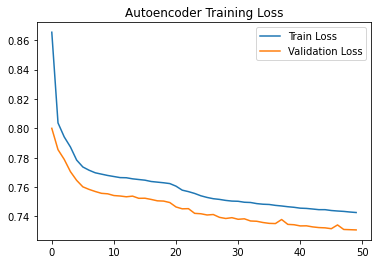

In [11]:
# Plot Training Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Autoencoder Training Loss")
plt.show()

In [12]:
# Compute Reconstruction Error
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

1781/1781 [==============================] - 3s 1ms/step


In [13]:
# Set threshold as 95th percentile of error
threshold = np.percentile(mse, 95)

In [14]:
# Autoencoder Predictions
y_pred_autoencoder = (mse > threshold).astype(int)

In [15]:
# ------------------------------
# **Isolation Forest Model**
# ------------------------------
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
iso_forest.fit(X_train)

IsolationForest(contamination=0.01, random_state=42)

In [16]:
# Isolation Forest Predictions
y_pred_iforest = iso_forest.predict(X_test)
y_pred_iforest = np.where(y_pred_iforest == -1, 1, 0)  # Convert -1 (fraud) to 1

In [17]:
# ------------------------------
# **Comparison of Both Models**
# ------------------------------
print("\n🔹 Autoencoder Performance:")
print(classification_report(y_test, y_pred_autoencoder))

print("\n🔹 Isolation Forest Performance:")
print(classification_report(y_test, y_pred_iforest))


🔹 Autoencoder Performance:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     56864
           1       0.03      0.90      0.06        98

    accuracy                           0.95     56962
   macro avg       0.52      0.92      0.52     56962
weighted avg       1.00      0.95      0.97     56962


🔹 Isolation Forest Performance:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.63      0.18        98

    accuracy                           0.99     56962
   macro avg       0.55      0.81      0.59     56962
weighted avg       1.00      0.99      0.99     56962



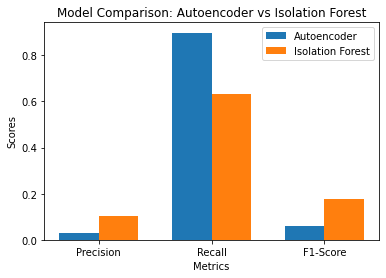

In [18]:
# ------------------------------
# **Comparison Plot**
# ------------------------------
labels = ["Precision", "Recall", "F1-Score"]

autoencoder_scores = [  
    classification_report(y_test, y_pred_autoencoder, output_dict=True)["1"]["precision"],
    classification_report(y_test, y_pred_autoencoder, output_dict=True)["1"]["recall"],
    classification_report(y_test, y_pred_autoencoder, output_dict=True)["1"]["f1-score"]
]

iforest_scores = [
    classification_report(y_test, y_pred_iforest, output_dict=True)["1"]["precision"],
    classification_report(y_test, y_pred_iforest, output_dict=True)["1"]["recall"],
    classification_report(y_test, y_pred_iforest, output_dict=True)["1"]["f1-score"]
]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, autoencoder_scores, width, label="Autoencoder")
bars2 = ax.bar(x + width/2, iforest_scores, width, label="Isolation Forest")

ax.set_xlabel("Metrics")
ax.set_ylabel("Scores")
ax.set_title("Model Comparison: Autoencoder vs Isolation Forest")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()
